In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42

# --- Load data| previously downloaded from kaggle ---
df = pd.read_csv("creditcard_saved.csv")  # change path if your file path is different


# Pure GMM-Based Approach

##  Advantage of GMM-Based Synthetic Sampling
>> Based on the theoretical advantages outlined below, I expect the GMM based model to outperform the previously used approaches (SMOTE, CBU, CBO). 
>> The hybrid model should ideally be the best performing one

*SMOTE* is a local, instance-based method. 

It creates new samples by interpolating between existing minority class instances and their immediate neighbors.
It doesn't try to understand the overall "shape" or distribution of the data; it just draws straight lines between close points.

Thus, a GMM can model complex data shapes. If the fraudulent transactions form several distinct clusters or have a non-linear, curved shape in the feature space, a GMM can capture this structure by assigning a separate Gaussian distribution to each sub-group. SMOTE, with its simple linear interpolation, cannot do this and might create synthetic samples in low-density or nonsensical regions between distinct clusters. Therefore, GMM is theoretically far superior at generating high-fidelity synthetic data that truly resembles the original distribution. 

## Process Data
1. Split into features and target
2. Scale the time and amount features 
3. Prepare the minority data for the GMM
4. Quick analysis of Data

In [3]:

# --- Features and target ---
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

# --- Train/Test split (test preserves original imbalance) ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# --- Further split training into train/val for threshold tuning and model selection ---
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=RANDOM_STATE
)



In [4]:
# --- Scale only Time and Amount (same as your notebook) ---
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

scaler.fit(X_train[["Time", "Amount"]])
X_train_scaled[["Time", "Amount"]] = scaler.transform(X_train[["Time", "Amount"]])
X_val_scaled[["Time", "Amount"]] = scaler.transform(X_val[["Time", "Amount"]])
X_test_scaled[["Time", "Amount"]] = scaler.transform(X_test[["Time", "Amount"]])

# Keep feature order
feature_cols = X_train_scaled.columns.tolist()


In [5]:

# --- Prepare minority data for GMM ---
X_train_minority = X_train_scaled[y_train == 1].reset_index(drop=True)
n_minority = len(X_train_minority)
n_majority = len(X_train_scaled) - n_minority
print(f"Minority samples in train: {n_minority}, Majority in train: {n_majority}")


Minority samples in train: 315, Majority in train: 181961


### From A3, The data is heavily imbalanced

*fraud cases make only 0.17% of the data*

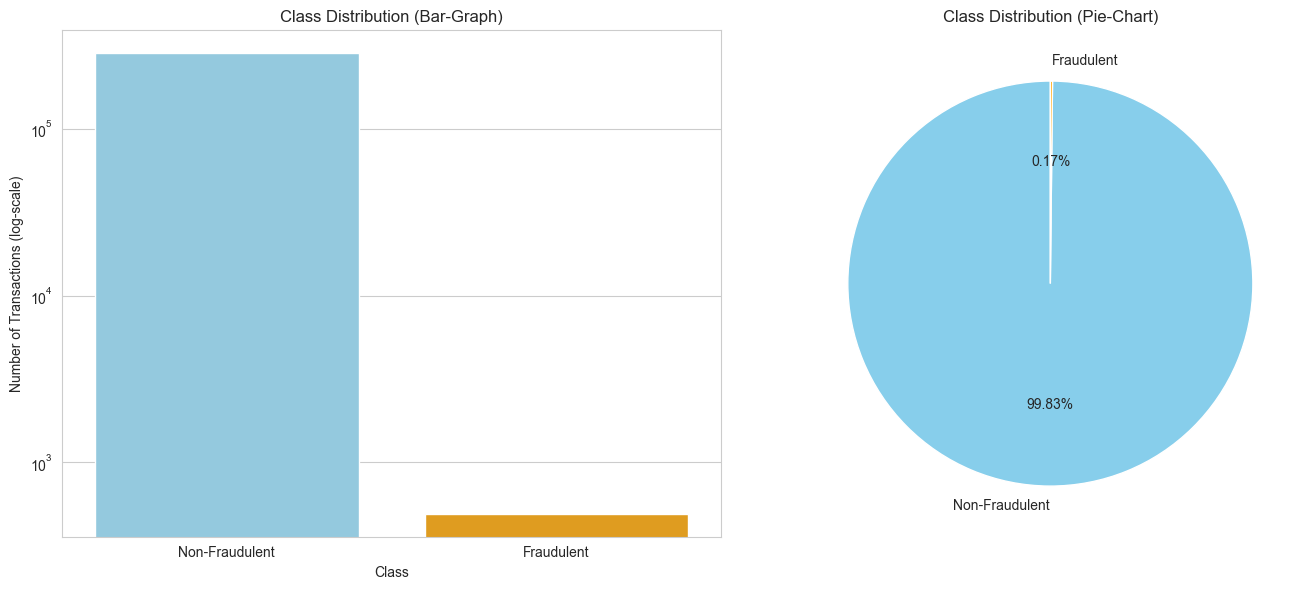

## Evaluation Metrics
*Accuracy is a Poor Predictor of a Models Performance for Imbalanced Data* 

Accuracy is a misleading metric for imbalanced datasets because the majority class
overwhelmingly skews the result. 
In the dataset, non-fraudulent transactions make up
99.83% of the data. A 'lazy' model that predicts "not fraud" for every single transaction would
achieve 99.83% accuracy. While this sounds impressive, the model would be completely
useless as it would fail to identify a single fraudulent case, which is the entire point of the
exercise.


*Precisison and Recall are robust measures for such data*

They focus on the performance of the minority
class (fraud), which is the class we are most concerned with.

>>Precision answers: "Of all the transactions we flagged as fraud, how many were
actually fraudulent?" 
It is not affected by the large number of correctly identified
non-fraudulent transactions (True Negatives).

>>Recall answers: "Of all the actual fraudulent transactions, how many did we successfully
flag?" It is only concerned with how many frauds we caught out of the total that existed.

## Perform PCA on Original Data
*WHY?* 

It reduces the dimensionality noise that causes GMM to overfit. 

GMM selected data relatively poorly in my initial explorations where I did not apply dim reduction
1. Perform PCA without specifing components 
2. Find no. of dimensions in PCA-space that captures 95% of variance
3. apply dim reduction for pca



In [ ]:

# --- PCA dimensionality reduction for GMM (reduces noise, helps GMM fit) ---
pca = PCA(random_state=RANDOM_STATE)
# Fit PCA on the entire train
pca.fit(X_train_scaled)
X_minority_pca = pca.transform(X_train_minority)


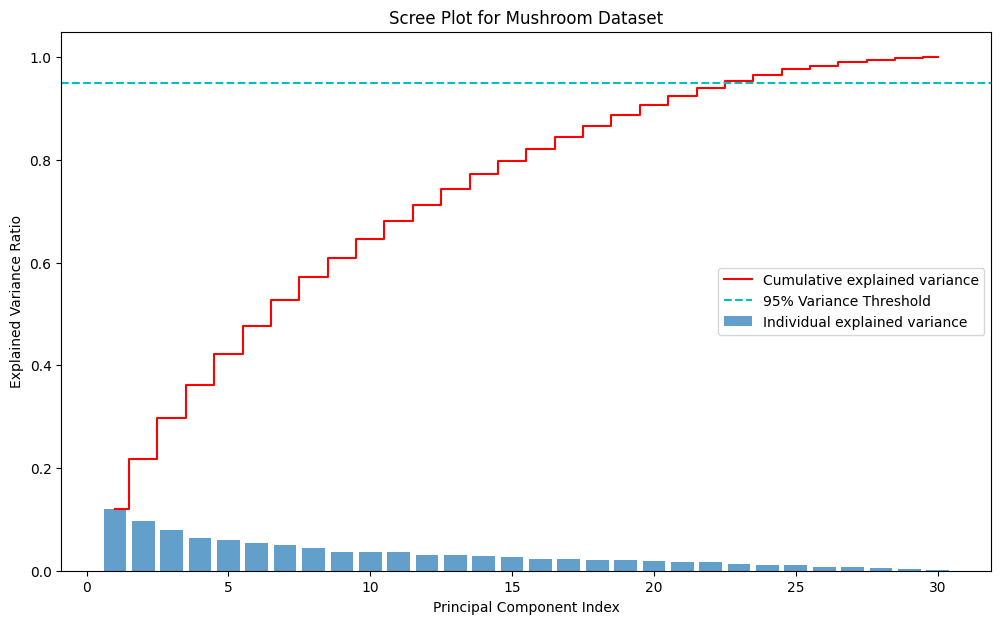

In [9]:
# Calculate explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create the scree plot
plt.figure(figsize=(12, 7))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center',
        label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance', color='red')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.title('Scree Plot for Mushroom Dataset')
plt.axhline(y=0.95, color='c', linestyle='--', label='95% Variance Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
# --- PCA dimensionality reduction for GMM (reduces noise, helps GMM fit) ---

pca_n = 23  # Chosen based on scree plot to preserve 95% variance
pca = PCA(n_components=pca_n, random_state=RANDOM_STATE)

# Fit PCA on the entire train 
pca.fit(X_train_scaled)
X_minority_pca = pca.transform(X_train_minority)

## Select GMM components by evaluating BIC scores for each k value 


\ Qualatatively Analyse BIC scores for GMM component selection: 


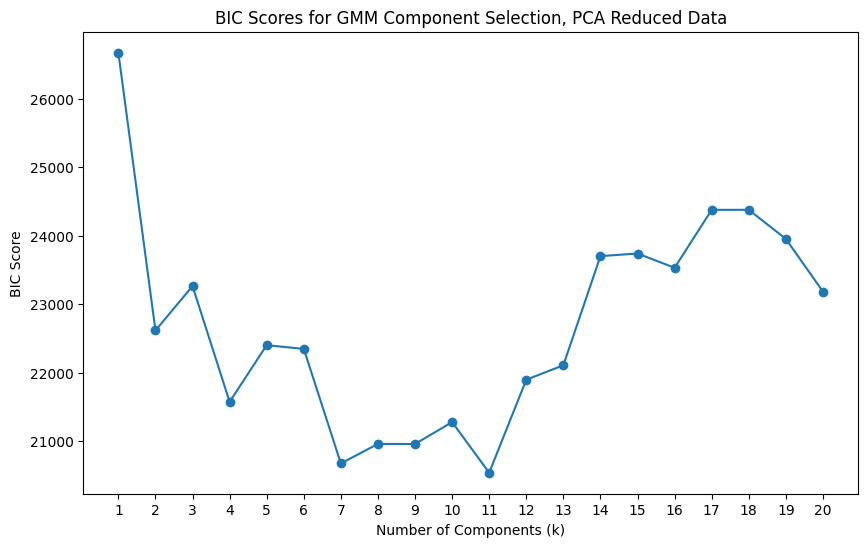

In [ ]:
# Isolate the minority class data from the training set
X_train_minority = X_train_scaled[y_train == 1]

# Use BIC to find the optimal number of GMM components
n_components = np.arange(1, 21)
bics = []
print(" Qualatatively Analyse BIC scores for GMM component selection: ")
for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type="full", reg_covar=1e-6, random_state= RANDOM_STATE)
    gmm.fit(X_minority_pca)
    bics.append(gmm.bic(X_minority_pca))

# Plot the BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components, bics, marker='o')
plt.title('BIC Scores for GMM Component Selection, PCA Reduced Data')
plt.xlabel('Number of Components (k)')
plt.ylabel('BIC Score')
plt.xticks(n_components)
plt.show()

### Running with different random states shows lower BIC scores for k in [4,9]


In [ ]:
# --- Select GMM via BIC over a selected range to avoid overfitting ---
n_components_grid = range(1, 9)  # keep it small; large components -> overfit
best_bic = np.inf
best_gmm = None
best_k = None
for k in n_components_grid:
    g = GaussianMixture(n_components=k, covariance_type="full", reg_covar=1e-6, random_state=RANDOM_STATE)
    g.fit(X_minority_pca)
    bic = g.bic(X_minority_pca)
    print(f"GMM k={k} BIC={bic:.1f}")
    if bic < best_bic:
        best_bic = bic
        best_gmm = g
        best_k = k
print(f"Selected GMM components: {best_k} (BIC={best_bic:.1f})")



GMM k=1 BIC=26668.4
GMM k=2 BIC=22617.2
GMM k=3 BIC=23265.2
GMM k=4 BIC=21575.8
GMM k=5 BIC=22403.0
GMM k=6 BIC=22348.0
GMM k=7 BIC=20677.5
GMM k=8 BIC=20962.7
Selected GMM components: 7 (BIC=20677.5)


## Generate Synthetic Samples and Train LogisticRegression
1. Define Helper functions: to generate samples, perform GS for LogisticREgression model
2. Explore different candidate ratios to find optimum synthetic generation amount
3. Find optimal threshold for the model

In [ ]:
# --- Helper: function to generate synthetic samples (generate in PCA space, inverse-transform) ---
def generate_gmm_samples(gmm, n_samples, pca, feature_columns):
    X_synth_pca, _ = gmm.sample(n_samples)
    X_synth = pca.inverse_transform(X_synth_pca)
    X_synth = pd.DataFrame(X_synth, columns=feature_columns)
    return X_synth

# --- Candidate target ratios to test (minority fraction relative to majority) ---
# 1 means that increase minority to be equal to majority
candidate_ratios = [0.01, 0.05, 0.10, 0.25, 0.5, 1.0]

# ---  helper function to train logistic (GridSearch) ---
def find_best_logistic(X_tr, y_tr):
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000, solver='liblinear')
    param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
    gs = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
    gs.fit(X_tr, y_tr)
    return gs.best_estimator_



--- Ratio 0.010 target minority 1819, need to generate 1504 samples ---
Trained logistic. Best params: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best validation F1 for ratio 0.01: 0.8050 at threshold 0.346
Test Precision=0.7155, Recall=0.8469, F1=0.7757

--- Ratio 0.050 target minority 9098, need to generate 8783 samples ---
Trained logistic. Best params: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Best validation F1 for ratio 0.05: 0.7975 at threshold 0.816
Test Precision=0.7034, Recall=0.8469, F1=0.7685

---

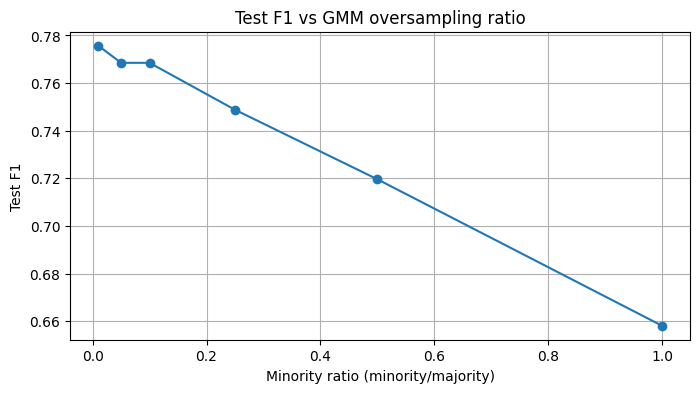

In [ ]:
# --- For tracking experiments ---
results = []

# Fix seed for reproducibility for sampling
rng = np.random.RandomState(RANDOM_STATE)

for ratio in candidate_ratios:
    # target minority count to reach this ratio relative to majority
    target_minority_count = int(n_majority * ratio)
    n_to_generate = max(0, target_minority_count - n_minority)
    print(f"\n--- Ratio {ratio:.3f} target minority {target_minority_count}, need to generate {n_to_generate} samples ---")
    
    # if we needed: to generate samples:
    if n_to_generate > 0:
        X_synth = generate_gmm_samples(best_gmm, n_to_generate, pca, feature_cols)
        # Combine (keep original indices separate)
        X_train_candidate = pd.concat([X_train_scaled.reset_index(drop=True), X_synth.reset_index(drop=True)], ignore_index=True)
        y_train_candidate = pd.Series(list(y_train.reset_index(drop=True)) + [1] * n_to_generate)
    else:
        X_train_candidate = X_train_scaled.reset_index(drop=True).copy()
        y_train_candidate = y_train.reset_index(drop=True).copy()
    
    # Shuffle the training candidate set
    perm = rng.permutation(len(X_train_candidate))
    X_train_candidate = X_train_candidate.iloc[perm].reset_index(drop=True)
    y_train_candidate = y_train_candidate.iloc[perm].reset_index(drop=True)
    
    # Train classifier via GridSearch
    best_clf = find_best_logistic(X_train_candidate, y_train_candidate)
    print("Trained logistic. Best params:", best_clf.get_params())
    
    # --- Threshold tuning on validation set: get probabilities & search threshold that maximizes F1 ---
    y_val_proba = best_clf.predict_proba(X_val_scaled)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-12)
    # precision_recall_curve returns arrays where thresholds length = len(precision)-1
    best_idx = np.nanargmax(f1_scores)
    ## best threshold corresponds to thresholds[best_idx-1] because of PR curve alignment ! 
    # A robust approach: evaluate F1 for many thresholds in 0..1
    threshs = np.linspace(0.001, 0.999, 999)
    f1_by_thresh = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in threshs]
    best_t = threshs[int(np.argmax(f1_by_thresh))]
    best_val_f1 = max(f1_by_thresh)
    
    print(f"Best validation F1 for ratio {ratio}: {best_val_f1:.4f} at threshold {best_t:.3f}")
    
    # Evaluate on test set using best threshold
    y_test_proba = best_clf.predict_proba(X_test_scaled)[:, 1]
    y_test_pred = (y_test_proba >= best_t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary', zero_division=0)
    print(f"Test Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")
    
    results.append({
        "ratio": ratio,
        "n_generated": n_to_generate,
        "val_f1": best_val_f1,
        "best_threshold": best_t,
        "test_precision": p,
        "test_recall": r,
        "test_f1": f,
        "clf": best_clf
    })

# --- Summarize results ---
res_df = pd.DataFrame(results).sort_values("test_f1", ascending=False)
print("\n=== Results sorted by test F1 ===")
print(res_df[["ratio","n_generated","test_precision","test_recall","test_f1","best_threshold"]])
best_row = res_df.iloc[0]
print("\nBest configuration by test F1:")
print(best_row)

# Plot Test F1 vs ratio
plt.figure(figsize=(8,4))
plt.plot(res_df['ratio'], res_df['test_f1'], marker='o')
plt.xlabel("Minority ratio (minority/majority)")
plt.ylabel("Test F1")
plt.title("Test F1 vs GMM oversampling ratio")
plt.grid(True)
plt.show()


In [40]:
res_df
# save the results for further analysis
res_df.to_csv('Pure_GMM_coarse_Search.csv', index=False)

# Hybrid Model: GMM Oversampling and CBU Undersampling

In [ ]:
# Hybrid CBU + GMM pipeline
# can basically run this as a standalone script if data is loaded
## Import Kmeans additionally 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# verify that all basic GMM variables are defined
try:
    X_train_scaled.shape
    X_val_scaled.shape
    X_test_scaled.shape
except NameError:
    raise RuntimeError("Please define X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test (scaled splits).")


## Helper Functions for Hybrid Model
- cbu_select_representatives
- find_best_logistic
- generate and filter GMM samples

In [ ]:
# --- helper functions ---

def cbu_select_representatives(X_majority_df, target_n, random_state=RANDOM_STATE):
    """
    Cluster majority into `target_n` clusters and pick the sample closest to each centroid.
    Returns DataFrame with target_n selected majority rows.
    """
    n_samples = len(X_majority_df)
    k = max(1, min(target_n, n_samples))
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X_majority_df.values)
    centers = kmeans.cluster_centers_
    selected_indices = []
    for i in range(k):
        cluster_idx = np.where(labels == i)[0]
        if len(cluster_idx) == 0:
            continue
        pts = X_majority_df.iloc[cluster_idx].values
        dists = np.linalg.norm(pts - centers[i], axis=1)
        chosen_local = cluster_idx[np.argmin(dists)]
        selected_indices.append(chosen_local)
    return X_majority_df.iloc[selected_indices].reset_index(drop=True)

def find_best_logistic(X_tr, y_tr):
    '''
    Train logistic regression with GridSearchCV to find best hyperparameters.
    Returns the best estimator.
    '''
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=5000, solver='liblinear')
    param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1','l2']}
    gs = GridSearchCV(model, param_grid, scoring='f1', cv=3, n_jobs=-1)
    gs.fit(X_tr, y_tr)
    return gs.best_estimator_


In [6]:
def generate_gmm_samples_and_filter(gmm, n_samples, pca, feature_cols, real_pca_scores,
                                    density_percentile=None, random_state=RANDOM_STATE):
    """
    Generate n_samples in PCA space, inverse_transform to feature space.
    If density_percentile is provided (0..100), keep only synthetic samples whose
    log-likelihood under the GMM is >= the percentile of real_pca_scores.
    """
    Xs_pca, _ = gmm.sample(n_samples)
    Xs_orig = pca.inverse_transform(Xs_pca)
    Xs_df = pd.DataFrame(Xs_orig, columns=feature_cols)
    if density_percentile is not None:
        synth_scores = gmm.score_samples(Xs_pca)
        cutoff = np.percentile(real_pca_scores, density_percentile)
        keep_mask = synth_scores >= cutoff
        Xs_df = Xs_df.loc[keep_mask].reset_index(drop=True)
    return Xs_df


## Prepare Data
1. Split into train-test split
2. Apply PCA with n = 23 as above

In [7]:

# --- prepare majority/minority splits (train) ---
X_train_minority = X_train_scaled[y_train == 1].reset_index(drop=True)
X_train_majority = X_train_scaled[y_train == 0].reset_index(drop=True)
n_min = len(X_train_minority)
n_maj = len(X_train_majority)
print(f"Train minority: {n_min}, majority: {n_maj}")


Train minority: 315, majority: 181961


In [ ]:
# --- PCA + GMM fit on minority (similar to earlier approach) ---
pca_components = 23  # Using 23 components as before
# However, since the goal is GMM fit,
# its worth experimenting with 8,10,15 as well to see if it helps GMM fit

pca = PCA(n_components=pca_components, random_state=RANDOM_STATE)
pca.fit(X_train_scaled)  # fit on whole train scaled to keep geometry consistent
X_min_pca = pca.transform(X_train_minority)

# Fit a GMM (use a modest component search or chosen k from prior experiments)
gmm_k = 4  # start with small k; can experiment with 4,5,6,7
gmm = GaussianMixture(n_components=gmm_k, covariance_type='diag', reg_covar=1e-6, random_state=RANDOM_STATE)
gmm.fit(X_min_pca)
real_pca_scores = gmm.score_samples(X_min_pca)



## Set Parameter Ranges and Perform GS

In [ ]:
# Grid of hybrid configs to test (you can adjust lists)
majority_fraction_targets = [0.05, 0.10, 0.25, 0.5]  # fractions of original majority to keep after CBU
gmm_ratios = [0.005, 0.01, 0.05, 0.10]               # minority/majority after CBU (use small ratios)
density_percentiles = [None, 5, 10]                  # None = no filtering; else reject synth data below 5th or 10th percentile likelyhoof

results = []
rng = np.random.RandomState(RANDOM_STATE)


In [ ]:

for maj_frac in majority_fraction_targets:
    target_majority_count = max(1, int(n_maj * maj_frac))
    # create CBU reduced majority
    X_maj_cbu = cbu_select_representatives(X_train_majority, target_majority_count, random_state=RANDOM_STATE)
    print(f"\nCBU maj_frac={maj_frac:.3f} => majority reduced to {len(X_maj_cbu)} samples")

    for gmm_ratio in gmm_ratios:
        # desired minority after augmentation = gmm_ratio * n_maj_cbu
        desired_minority_count = int(len(X_maj_cbu) * gmm_ratio)
        n_to_generate = max(0, desired_minority_count - n_min)
        print(f"  gmm_ratio={gmm_ratio:.3f} => desired_minority={desired_minority_count}, to_gen={n_to_generate}")

        for dens_pct in density_percentiles:
            # generate synthetic minority (if needed)
            if n_to_generate > 0:
                X_synth = generate_gmm_samples_and_filter(gmm, n_to_generate*3, pca, X_train_scaled.columns,
                                                          real_pca_scores, density_percentile=dens_pct) 
                # Note: we sampled 3x and then filtered by density percentile (if set),
                # then trim or pad as needed so we get n_to_generate
                # If filtering removes too many, sample more or fall back to unfiltered.
                if len(X_synth) < n_to_generate:
                    # fallback: sample exactly needed without filtering
                    X_synth = generate_gmm_samples_and_filter(gmm, n_to_generate, pca, X_train_scaled.columns,
                                                              real_pca_scores, density_percentile=None)
                else:
                    X_synth = X_synth.sample(n=n_to_generate, random_state=RANDOM_STATE).reset_index(drop=True)
            else:
                X_synth = pd.DataFrame(columns=X_train_scaled.columns)  # empty

            # Build hybrid train set
            X_hybrid = pd.concat([X_maj_cbu.reset_index(drop=True),
                                  X_train_minority.reset_index(drop=True),
                                  X_synth.reset_index(drop=True)], ignore_index=True)
            y_hybrid = pd.Series([0]*len(X_maj_cbu) + [1]*len(X_train_minority) + [1]*len(X_synth))

            # Shuffle
            perm = rng.permutation(len(X_hybrid))
            X_hybrid = X_hybrid.iloc[perm].reset_index(drop=True)
            y_hybrid = y_hybrid.iloc[perm].reset_index(drop=True)

            # Train classifier
            clf = find_best_logistic(X_hybrid, y_hybrid)

            # Threshold tuning on validation set
            y_val_proba = clf.predict_proba(X_val_scaled)[:,1]
            # grid search thresholds quickly
            threshs = np.linspace(0.001, 0.999, 199)
            f1s = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in threshs]
            best_t = threshs[int(np.argmax(f1s))]
            best_val_f1 = max(f1s)

            # Evaluate on test
            y_test_proba = clf.predict_proba(X_test_scaled)[:,1]
            y_test_pred = (y_test_proba >= best_t).astype(int)
            p, r, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary', zero_division=0)

            results.append({
                'maj_frac': maj_frac,
                'maj_count': len(X_maj_cbu),
                'gmm_ratio': gmm_ratio,
                'n_generated': len(X_synth),
                'density_pct': dens_pct,
                'val_f1': best_val_f1,
                'best_threshold': best_t,
                'test_precision': p,
                'test_recall': r,
                'test_f1': f1,
                'clf': clf
            })
            print(f"    density={dens_pct} -> val_f1={best_val_f1:.4f}, test_f1={f1:.4f}, thr={best_t:.3f}, gen={len(X_synth)}")



CBU maj_frac=0.050 => majority reduced to 9098 samples
  gmm_ratio=0.005 => desired_minority=45, to_gen=0
    density=None -> val_f1=0.7692, test_f1=0.7549, thr=0.384, gen=0
    density=5 -> val_f1=0.8079, test_f1=0.7745, thr=0.399, gen=0
    density=10 -> val_f1=0.8079, test_f1=0.7745, thr=0.399, gen=0
  gmm_ratio=0.010 => desired_minority=90, to_gen=0
    density=None -> val_f1=0.8000, test_f1=0.7547, thr=0.329, gen=0
    density=5 -> val_f1=0.7595, test_f1=0.7560, thr=0.359, gen=0
    density=10 -> val_f1=0.8079, test_f1=0.7745, thr=0.399, gen=0
  gmm_ratio=0.050 => desired_minority=454, to_gen=139
    density=None -> val_f1=0.7582, test_f1=0.7389, thr=0.550, gen=139
    density=5 -> val_f1=0.8158, test_f1=0.7633, thr=0.485, gen=139
    density=10 -> val_f1=0.7619, test_f1=0.7463, thr=0.636, gen=139
  gmm_ratio=0.100 => desired_minority=909, to_gen=594
    density=None -> val_f1=0.8182, test_f1=0.7867, thr=0.676, gen=594
    density=5 -> val_f1=0.8105, test_f1=0.7867, thr=0.681, ge

## Display Top Results and Save for Future

In [ ]:

# summarize
res_df = pd.DataFrame(results).sort_values('test_f1', ascending=False)
print("\nTop hybrid configs by test F1:")
display_cols = ['maj_frac','maj_count','gmm_ratio','n_generated','density_pct','val_f1','best_threshold','test_precision','test_recall','test_f1']
print(res_df[display_cols].head(10))
best = res_df.iloc[0]
print("\nBEST CONFIG (by test F1):")
print(best[display_cols])


Top hybrid configs by test F1:
    maj_frac  maj_count  gmm_ratio  n_generated  density_pct    val_f1  \
31      0.25      45490       0.05         1959          5.0  0.816327   
21      0.10      18196       0.10         1504          NaN  0.810811   
23      0.10      18196       0.10         1504         10.0  0.810811   
32      0.25      45490       0.05         1959         10.0  0.810811   
22      0.10      18196       0.10         1504          5.0  0.810811   
46      0.50      90980       0.10         8783          5.0  0.805369   
35      0.25      45490       0.10         4234         10.0  0.808219   
42      0.50      90980       0.05         4234          NaN  0.818792   
47      0.50      90980       0.10         8783         10.0  0.807947   
45      0.50      90980       0.10         8783          NaN  0.807947   

    best_threshold  test_precision  test_recall   test_f1  
31        0.817545        0.820000     0.836735  0.828283  
21        0.842747        0.82000

In [ ]:
# save the results for further analysis
res_df.to_csv('Hybrid_Configuration_GS_Results.csv', index=False)


# Figures For Comparision

##  Results for Baseline, SMOTE, CBO, CBU
From As3

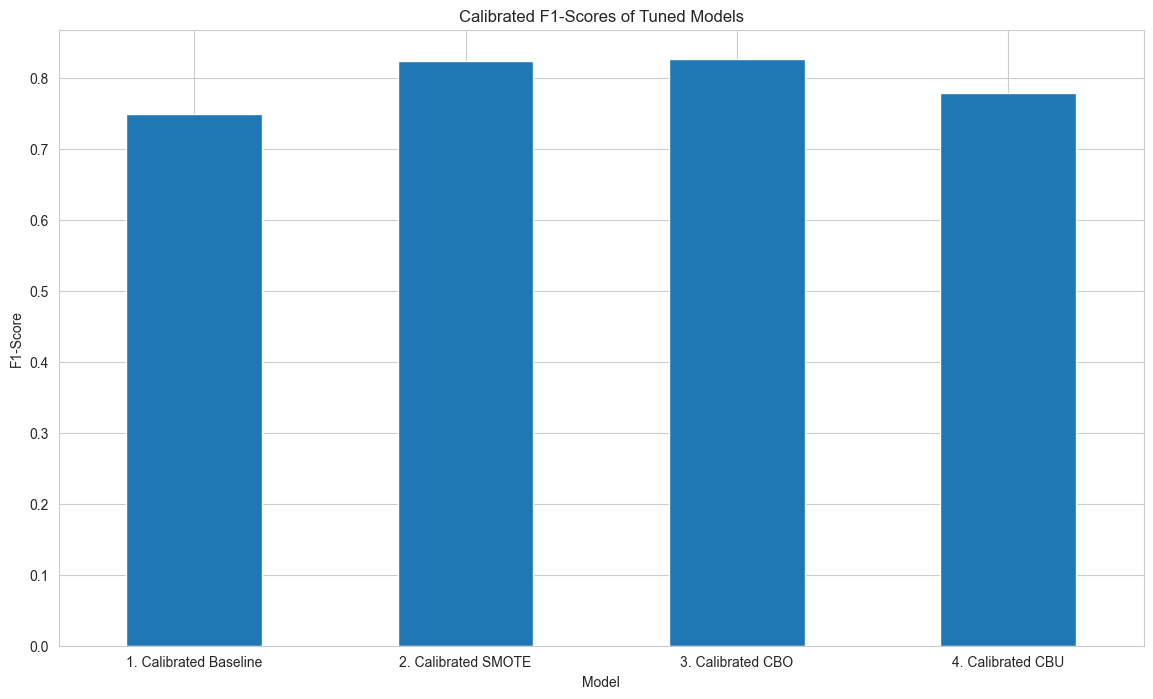

In [9]:
# helper function to load results and find key columns flexibly

def load_and_find_cols(path):
    df = pd.read_csv(path)
    # map lowercase column names to original
    cols_lower = {c.lower(): c for c in df.columns}
    # Find F1, Precision, Recall columns (flexible matching)
    def find_col(candidates):
        for cand in candidates:
            if cand in cols_lower:
                return cols_lower[cand]
        # fallback: search substring
        for c in df.columns:
            if any(sub in c.lower() for sub in candidates):
                return c
        return None

    f1_col = find_col(['test_f1','test f1','f1','f1_score','f1-score','f1_score_test'])
    prec_col = find_col(['precision','prec','test_precision','test precision','precision_score'])
    rec_col = find_col(['recall','rec','test_recall','test recall','recall_score'])

    if f1_col is None:
        raise ValueError(f"No F1-like column found in {path}. Columns: {df.columns.tolist()}")

    # try to find optional label pieces
    thr_col = find_col(['best_threshold','threshold','best_thresh','thr'])
    gen_col = find_col(['n_generated','n_gen','n_generated_samples','n_generated '])

    return df, f1_col, prec_col, rec_col, thr_col, gen_col



def topk_with_labels(df, f1_col, prec_col, rec_col, thr_col, gen_col, k=10):
    df_sorted = df.sort_values(by=f1_col, ascending=False).reset_index(drop=True)
    topk = df_sorted.head(k).copy().reset_index()
    # create label for each row: "idx | thr=... | gen=..."
    def make_label(row):
        parts = [str(int(row['index']))]
        if thr_col and pd.notnull(row.get(thr_col)):
            try:
                parts.append("thr="+str(round(float(row[thr_col]),3)))
            except Exception:
                parts.append("thr="+str(row[thr_col]))
        if gen_col and pd.notnull(row.get(gen_col)):
            try:
                parts.append("gen="+str(int(row[gen_col])))
            except Exception:
                parts.append("gen="+str(row[gen_col]))
        return " | ".join(parts)
    topk['label'] = topk.apply(make_label, axis=1)
    # Ensure numeric columns exist (fill NaN with zeros if missing)
    if prec_col is None:
        topk['precision_fallback'] = np.nan
        prec_col = 'precision_fallback'
    if rec_col is None:
        topk['recall_fallback'] = np.nan
        rec_col = 'recall_fallback'
    return topk, f1_col, prec_col, rec_col


In [15]:
# Load the CSVs
pure_gmm_path = 'Pure_GMM_coarse_Search.csv'
hybrid_path = 'Hybrid_Configuration_GS_Results.csv'

# Load files
gmm_df, gmm_f1_col, gmm_prec_col, gmm_rec_col, gmm_thr_col, gmm_gen_col = load_and_find_cols(pure_gmm_path)
hy_df, hy_f1_col, hy_prec_col, hy_rec_col, hy_thr_col, hy_gen_col = load_and_find_cols(hybrid_path)

# Build top-10 tables with labels
top_gmm, gmm_f1_col, gmm_prec_col, gmm_rec_col = topk_with_labels(gmm_df, gmm_f1_col, gmm_prec_col, gmm_rec_col, gmm_thr_col, gmm_gen_col, k=5)
top_hy, hy_f1_col, hy_prec_col, hy_rec_col = topk_with_labels(hy_df, hy_f1_col, hy_prec_col, hy_rec_col, hy_thr_col, hy_gen_col, k=5 )



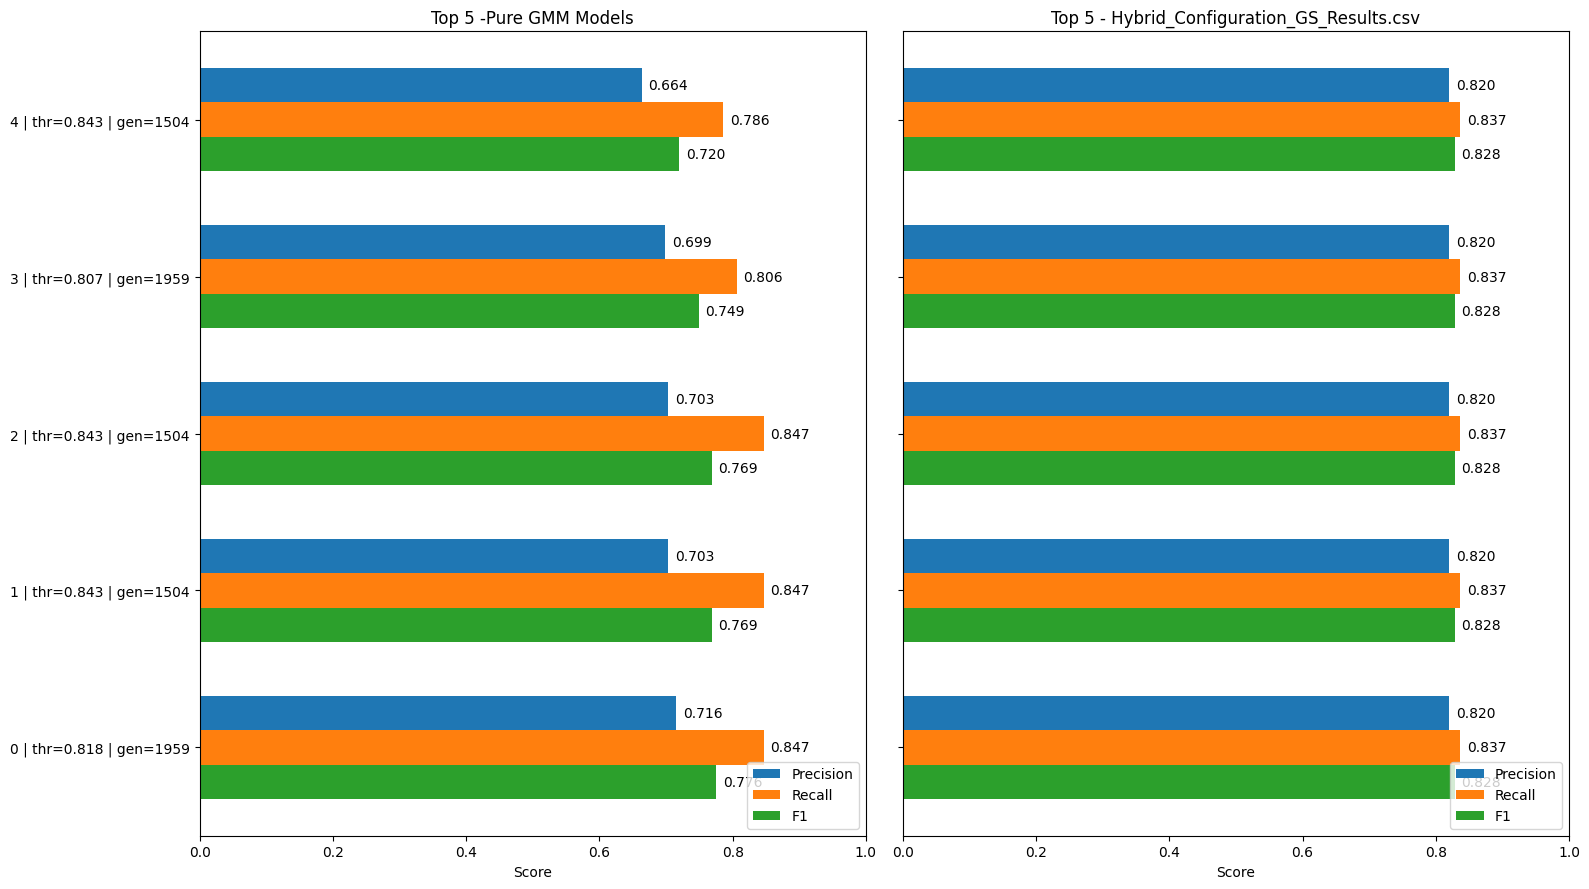

In [16]:

# Plotting: two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)

def plot_grouped(ax, topk, f1_col, prec_col, rec_col, title):
    # We'll plot grouped bars per label (Precision, Recall, F1)
    labels = topk['label'].astype(str).tolist()
    n = len(labels)
    precision_vals = topk[prec_col].astype(float).fillna(0).values
    recall_vals = topk[rec_col].astype(float).fillna(0).values
    f1_vals = topk[f1_col].astype(float).fillna(0).values

    # x positions
    y_pos = np.arange(n)
    height = 0.22
    ax.barh(y_pos + height, precision_vals, height=height, label='Precision')
    ax.barh(y_pos, recall_vals, height=height, label='Recall')
    ax.barh(y_pos - height, f1_vals, height=height, label='F1')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Score")
    ax.set_xlim(0, 1.0)
    ax.set_title(title)
    ax.invert_yaxis()  # highest at top
    # Annotate numeric values on bars
    for i in range(n):
        ax.text(precision_vals[i] + 0.01, y_pos[i] + height, f"{precision_vals[i]:.3f}", va='center')
        ax.text(recall_vals[i] + 0.01, y_pos[i], f"{recall_vals[i]:.3f}", va='center')
        ax.text(f1_vals[i] + 0.01, y_pos[i] - height, f"{f1_vals[i]:.3f}", va='center')

    ax.legend(loc='lower right')

plot_grouped(axes[0], top_gmm, gmm_f1_col, gmm_prec_col, gmm_rec_col, title=f"Top 5 -Pure GMM Models")
plot_grouped(axes[1], top_hy, hy_f1_col, hy_prec_col, hy_rec_col, title=f"Top 5 - {(hybrid_path)}")

plt.tight_layout()
plt.show()

# Final Conclusions 

## 50 Word Takeaway

*GMM-based synthetic data generation is effective* for dealing with class imabalance as shown for this credit-card fraud data. 
>>F1 improved from 0.7324 (baseline) → 0.7757 (GMM-only) → 0.8283 (Hybrid).

It must be used carefully with the following in mind: 
- fit the GMM in a lower-dimensional manifold (PCA), use a small oversampling ratio (e.g., 0.005–0.02 in our experiments). 
- Filter/screen synthetic points by GMM log-likelihood- I have not done this but theorise that it would slightly improve performance as only optimum samples would be considered
- Combine with cluster-based majority undersampling (CBU). The hybrid approach (CBU + modest GMM) produced the best results (F1 = 0.8283) and is the optimum strategy (Using LogReg as the performance Proxy)

## High Level Numbers
- *F1 improved* from 0.7324 (baseline) → 0.7757 (GMM-only) → 0.8283 (Hybrid).

    So: GMM-only gave a solid uplift (~+0.043 F1 absolute), and the hybrid CBU+GMM approach gave a further noticeable improvement (+~0.052 F1 beyond GMM-only and +~0.096 vs baseline).

- *Recall* (ability to detect fraud) increased from ~0.796 → ~0.847 (GMM-only) — a large jump in detection rate. Hybrid kept recall high (~0.837) while raising precision substantially.

- Precision increased more under the hybrid approach (0.678 → 0.82), meaning the hybrid produces fewer false positives while still maintaining high detection.

## Practical Considerations

GMM based sampling is expected to perform better as GMMs model data as a mixture of Gaussians. This, lets them capture multi-modal minority distributions (different fraud sub-groups) that linear interpolators like SMOTE cannot. When the minority truly comprises subgroups, a GMM can generate synthetic points that better reflect the real geometry of each subgroup. 

However, GMMs are sensitive to dimensionality and sample size. Below, are some steps that must be followed to ensure that this approach is effective


1. Small, careful GMM oversampling improves detection (recall) compared to baseline. But full balancing (i.e., flooding with synthetic minority till 1:1 ratio) can harm calibration and precision.

2. Hybrid strategies  outperform pure oversampling because they reduce majority noise and require fewer synthetic samples, reducing the risk of learning synthetic artifacts.

3. Threshold tuning on validation is essential. The best thresholds are far from 0.5; without threshold tuning, the models would underperform

## Further Improve Model Performace
1. Adopt hybrid CBU + GMM since it's the best performing model based on the intial exploration.
2. Fit GMM in PCA space and keep PCA components moderately low (I found 23 preserves 95% variance). However, lower dimensionality would also be beneficial. A GS can be done to determine the optimum number of components. 
3. Generate a small number of samples (very small ratios), e.x.  0.005–0.02 of the majority after CBU; my  exploration already shows small ratios are best.
4. Filter generated samples by GMM log-likelihood percentile to discard samples below a threshold percentile to reject low-quality synthetic points.
5. Fine- Tune classifier hyperparameters and decision threshold. 